# Generation of "Similar" Sequences Using The Recurrent Variational Auto Encoder

# Introduction

I'm doing a thing to generate similar protein sequences, eventually.

In [1]:
# To Try:
# * Deeper Network with the dense layers
#   * Batch norm, higher lr 
#     https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/
#     If this causes dying ReLU, look into LeakyReLU, etc. 
# * Optimizing just the LSTM in the encoder and possibly decoder
import keras

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.layers import Bidirectional, Dense, Embedding
from keras.layers import Input, Lambda, LSTM, RepeatVector
from keras.layers import Flatten, TimeDistributed, Layer, BatchNormalization
from keras.layers import Activation, Dropout, Activation
from keras.layers.advanced_activations import ELU

from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, RMSprop
from keras import objectives

from keras.models import Model

from keras import backend as K
from keras.utils import plot_model, get_file

import numpy as np
import pandas as pd

import os
from IPython.display import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Data

### Overview

We are working with a file that contains
sequences. Each sequence is on a new line.
Because of the way the sequences are pulled,
there are additional "-" characters used for
alignment. We will strip these out, and pad
the front of the sequences.

In [2]:
url = 'https://raw.githubusercontent.com/badriadhikari'
deepcon_path = 'DEEPCON/master/deepcon-covariance/test'
file = '16pkA0.aln'
filepath = os.path.join(url, deepcon_path, file)
file = get_file(file, filepath)

with open(file, 'r') as sequence_file:
    sequences = sequence_file.read() \
                             .replace('-', '') \
                             .split('\n')

sequence_count = len(sequences)
print(f'[+] {sequence_count} Sequences in {file}')
print(f'[+] Subset of Sequences:')
print('\n\n'.join(sequences[:5]))

[+] 707 Sequences in /home/das-hund/.keras/datasets/16pkA0.aln
[+] Subset of Sequences:
EKKSINECDLKGKKVLIRVDFNVPVKNGKITNDYRIRSALPTLKKVLTEGGSCVLMSHLGRPKGIPMAQAGKIRSTGGVPGFQQKATLKPVAKRLSELLLRPVTFAPDCLNAADVVSKMSPGDVVLLENVRFYKEEGSKKAKDREAMAKILASYGDVYISDAFGTAHRDSATMTGIPKILGNGAAGYLMEKEISYFAKVLGNPPRPLVAIVGGAKVSDKIQLLDNMLQRIDYLLIGGAMAYTFLKAQGYSIGKSKC

MYNKTVLVRVDFNVPIRNGVIAKDQRIRAALPTIRAIIDQGGKAVLMSHMGRPQGHQLDALINDERLRQYYGFEDELSLKPVAKRLSELLNEVVKFAEDCMNAEGIVAELEPGQVILLENVRFYNDETSRVESERLAMAKHIASYGDFFVSDAFGTSHRNSATVVGLPTVMGHGCCGYLLKREIEAYSDLLGEPNRPMVAIVGGAKVSDKILLLDHILPQIDSLIIGGAMAFTFLKVQGYDIANSFH

IKGKVVLVRVDLNVRIEISFDLRLLSCYKAVLISHVGRPVGHKWSILKDNKQLRSYNGFKDELSLRPVAARLSDLLNENVSFAPDCLAAADEVAALQPGDVLVLENVRFYSDENSMADEERLAMAKILASYGDYYVSEAFGTSHRNSATMVDLPRVMGHGCCGSLMETELAAFSNVTDRTPRPTCAIIGGVKVTEKILMVEHLLNRIQYLVVGGAMSFTFLKAAGYKIGNSFH

LRNKRVLLRVDFNVPVKDGIITNDHRIRSALPTIQKVLQSGGSCVLMSHLGRPKGAPMSAAASCGDGSAPGYEAEATLRPVAERLQELLDLPVTFAPDCLNATSIVEKLQPGGVVLLENVRFYCEEGSKKEEERHAMARVLASYGDVFVSDAFGTAHRDSATMTGIPKVL

### Tokenize

After splitting the texts by new lines, we
want to map the characters to integers. Note
that we use the `char_level` argument to 
tokenize characters instead of words. 

Fortunately, we don't need to limit the 
number of tokens. There aren't many amino
acids available. Worth noting, the last 
layer is currently one hot encoded. This
is **absolutely** worth optimizing; 
however, time is a factor. 

We will also pad the sequences. To start,
we also won't be limiting sequence length.
I'll do some simple analysis to get a
distribution of sequence length. This will
give us an idea of whether it's worth
limiting the length. 

#### Train the Tokenizer

In [3]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
word_to_index = tokenizer.word_index
index_to_word = {
    index: word 
    for word, index in word_to_index.items()
}

In [4]:
sequences = tokenizer.texts_to_sequences(sequences)

#### Summary Stats 

[+] Max Sequence Length: 256
[+] Word Count: 21


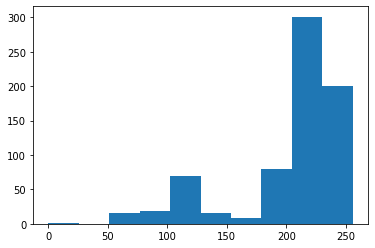

In [5]:
sequence_lengths = np.array([
    len(seq) for seq in sequences
])

max_seq_len = max(sequence_lengths)
word_count = len(word_to_index)

print(f'[+] Max Sequence Length: {max_seq_len}')
print(f'[+] Word Count: {word_count}')

%matplotlib inline
plt.hist(sequence_lengths)

# ToDo: Update the names of these params.
MAX_WORDS = word_count
MAX_SEQ_LEN = max_seq_len

In [6]:
print(f'[+] {len(word_to_index)} words found in {file}')

print('[+] Word Map Subset:\n{')
for acid, index in word_to_index.items():
    print('\t{}: {}'.format(acid, index))
print('}')

[+] 21 words found in /home/das-hund/.keras/datasets/16pkA0.aln
[+] Word Map Subset:
{
	l: 1
	a: 2
	v: 3
	g: 4
	k: 5
	i: 6
	e: 7
	s: 8
	d: 9
	r: 10
	f: 11
	n: 12
	p: 13
	t: 14
	q: 15
	h: 16
	m: 17
	y: 18
	c: 19
	w: 20
	x: 21
}


#### Data Subset

When training the RNNS, we will need to limit the
length of the data to a multiple of what our batch
size will be. In the future, we will also perform 
the train test split here. But, for now, we just
select a random subset of the data. This will serve
as our development set. 

In [7]:
DATA_LEN = 512
np.random.shuffle(sequences)
sequences = sequences[:DATA_LEN]

#### Pad Sequences

In [8]:
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

In [9]:
print(padded_sequences[0:5])
print(padded_sequences.shape)

[[ 0  0  0 ... 15  8  3]
 [ 0  0  0 ...  8  1 11]
 [ 0  0  0 ...  2 14  3]
 [ 0  0  0 ...  8  1 19]
 [ 0  0  0 ...  8  1 11]]
(512, 256)


In [10]:
#padded_sequences = padded_sequences.reshape((512, 256, 1))

## Model Architecture

Note I'm not using the GLOVE embeddings here.
That would make it difficult to transition this
model to protein sequences. 

In [11]:
from keras.layers.advanced_activations import ELU


def build_encoder(embedding, max_seq_len, 
                  latent_dim, intermediate_dim,
                  epsilon_std):
    h = Bidirectional(LSTM(
        intermediate_dim, return_sequences=True, name='lstm_encoding_one'
    ), merge_mode='concat', name='bidirectional_encoding_one')(embedding)
    h = Bidirectional(LSTM(
        intermediate_dim, return_sequences=False, name='lstm_encoding_two'
    ), merge_mode='concat', name='bidirectional_encoding_two')(h)
    
    h = Dense(
        intermediate_dim, activation='relu', name='dense_encoding_one'
    )(h)
    h = BatchNormalization(name='bn_one')(h)
    h = Dense(
        intermediate_dim, activation='relu', name='dense_encoding_two'
    )(h)
    h = BatchNormalization(name='bn_two')(h)
    h = Dense(
        intermediate_dim // 2, activation='relu', name='dense_encoding_three'
    )(h)
    

    def sampling(args):
        z_mean_, z_log_var_ = args
        batch_size = K.shape(z_mean_)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
        return z_mean_ + K.exp(z_log_var_ / 2) * epsilon
    
    z_mean = Dense(latent_dim, activation='linear', name='z_mean')(h)
    z_log_var = Dense(latent_dim, activation='linear', name='z_log_var')(h)
    
    def vae_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_seq_len * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    latent = Lambda(
        sampling, output_shape=(latent_dim,), name='latent'
    )([z_mean, z_log_var])
    
    return vae_loss, latent


def build_decoder(encoded_input, intermediate_dim,
                  token_count, max_seq_len):
    repeated_context = RepeatVector(
        max_seq_len, name='repeated_context'
    )(encoded_input)
    
    h = LSTM(
        intermediate_dim, return_sequences=True, name='lstm_decoding_one'
    )(repeated_context)
    h = LSTM(
        intermediate_dim, return_sequences=True, name='lstm_decoding_two'
    )(h)
    
    decoded = TimeDistributed(Dense(
        token_count, activation='softmax', name='time_distributed_decoding'
    ), name='decoded_mean')(h)
    
    return decoded
    
    
def build_model(max_seq_len, embedding_dim, token_count,
                batch_size, intermediate_dim, 
                latent_dim, epsilon_std=0.1):
    # ENCODER
    encoder_input = Input(shape=(max_seq_len, 1), name='encoder_input')
    embedding = Embedding(
        token_count, embedding_dim,
        input_length=max_seq_len, name='embedding'
    )(encoder_input)
    
    vae_loss, encoded = build_encoder(
        embedding=embedding, max_seq_len=max_seq_len,
        latent_dim=latent_dim, intermediate_dim=intermediate_dim,
        epsilon_std=epsilon_std
    )
    
    encoder = Model(encoder_input, encoded, name='encoder')
    
    # DECODER
    encoded_input = Input(shape=(latent_dim,), name='encoded_input')
    decoded = build_decoder(
        encoded_input=encoded_input, intermediate_dim=intermediate_dim,
        token_count=token_count, max_seq_len=max_seq_len
    )
    
    decoder = Model(encoded_input, decoded, name='decoder')
    
    # VAE
    vae = Model(
        encoder_input, 
        build_decoder(
            encoded_input=encoded, intermediate_dim=intermediate_dim,
            token_count=token_count, max_seq_len=max_seq_len
        ), 
        name='vae')
    vae.compile(
        optimizer='adam',
        loss=vae_loss,
        metrics=['accuracy']
    )
    
    return vae, encoder, decoder


In [12]:
MAX_SEQUENCE_LENGTH = MAX_SEQ_LEN
EMBED_DIM = 16
WORD_COUNT = MAX_WORDS + 1
BATCH_SIZE = 64
STEPS_PER_EPOCH = DATA_LEN // BATCH_SIZE
INTERMEDIATE_DIM = 128
LATENT_DIM = 32

vae, encoder, decoder = build_model(
    max_seq_len=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    token_count=WORD_COUNT,
    batch_size=BATCH_SIZE,
    intermediate_dim=INTERMEDIATE_DIM,
    latent_dim=LATENT_DIM,
    epsilon_std=0.1
)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
def complex_oh_encode(X_train, maxlen, num_words):
    temp = np.zeros((X_train.shape[0], maxlen, num_words))
    temp[
        np.expand_dims(
            np.arange(X_train.shape[0]), axis=0
        ).reshape(
            X_train.shape[0], 1
        ), np.repeat(
            np.array([np.arange(maxlen)]), X_train.shape[0], axis=0
        ), X_train
    ] = 1
    return temp

In [14]:
# Will need this when we get the model working.
def batch_generator(X, batch_size, max_seq_len, num_words):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
        np.random.shuffle(indices) 
        for i in indices:
            batch.append(i)
            if len(batch)==batch_size:
                yield X[batch], complex_oh_encode(X[batch], maxlen=max_seq_len, num_words=num_words)
                batch=[]

train_generator = batch_generator(
    X=padded_sequences, batch_size=BATCH_SIZE,
    max_seq_len=MAX_SEQUENCE_LENGTH,
    num_words=WORD_COUNT
)

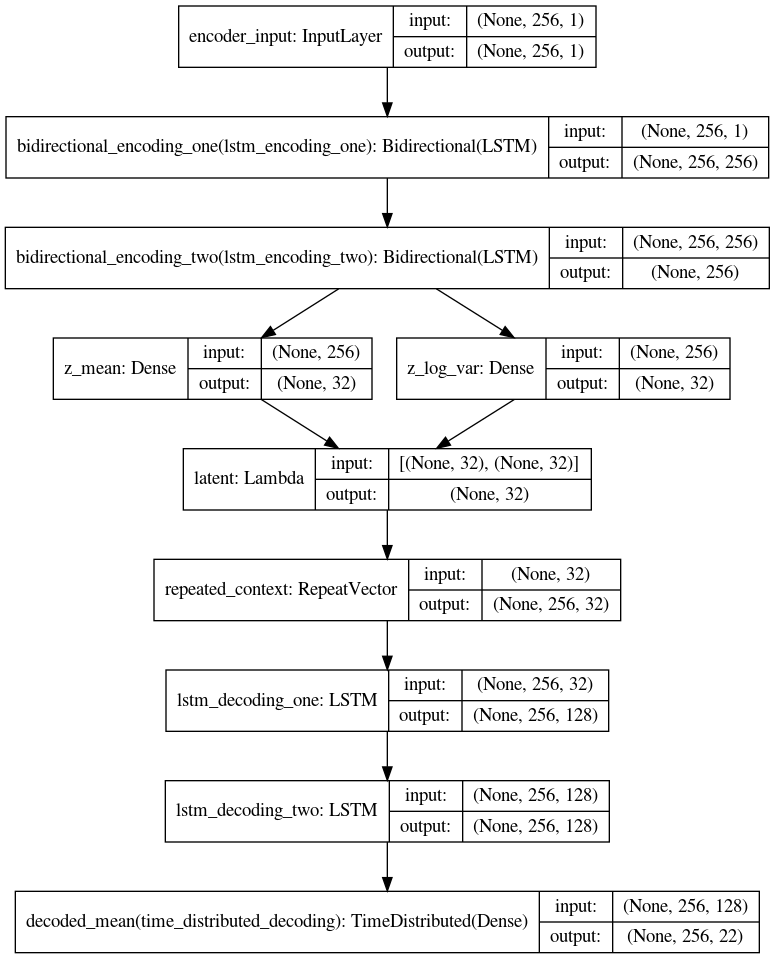

In [15]:
plot_model(vae, show_shapes=True, show_layer_names=True, to_file='vae.png')
Image(retina=True, filename='vae.png')

In [16]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 256, 1)       0                                            
__________________________________________________________________________________________________
bidirectional_encoding_one (Bid (None, 256, 256)     133120      encoder_input[0][0]              
__________________________________________________________________________________________________
bidirectional_encoding_two (Bid (None, 256)          394240      bidirectional_encoding_one[0][0] 
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 32)           8224        bidirectional_encoding_two[0][0] 
__________________________________________________________________________________________________
z_log_var 

In [21]:
# TODO: Add metrics for KL Div & Expectation
history = vae.fit_generator(
    train_generator, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    epochs=32
)

Epoch 1/32
8/8 [==============================] - 9s 1s/step - loss: 34.9946 - acc: 0.3064
Epoch 2/32
8/8 [==============================] - 9s 1s/step - loss: 35.4288 - acc: 0.3048
Epoch 3/32
8/8 [==============================] - 9s 1s/step - loss: 35.9952 - acc: 0.2938
Epoch 4/32
8/8 [==============================] - 9s 1s/step - loss: 35.0514 - acc: 0.3101
Epoch 5/32
8/8 [==============================] - 9s 1s/step - loss: 35.1957 - acc: 0.3055
Epoch 6/32
8/8 [==============================] - 9s 1s/step - loss: 34.9253 - acc: 0.3092
Epoch 7/32
8/8 [==============================] - 9s 1s/step - loss: 34.6977 - acc: 0.3131
Epoch 8/32
8/8 [==============================] - 9s 1s/step - loss: 35.0027 - acc: 0.3071
Epoch 9/32
8/8 [==============================] - 9s 1s/step - loss: 34.6493 - acc: 0.3154
Epoch 10/32
8/8 [==============================] - 9s 1s/step - loss: 35.4417 - acc: 0.2983
Epoch 11/32
8/8 [==============================] - 9s 1s/step - loss: 35.2052 - acc: 0.30

In [22]:
predictors = padded_sequences.reshape((512, 256, 1))
preds = vae.predict(predictors[0:10])


In [23]:
' '.join([
    index_to_word[i] if i != 0 else ''
    for i in padded_sequences[8]
]).strip()

't v t s a i k n k k v l l r v d f n v p i k d g r v i d d s r i r a h l e t i r f l s s n g a t v l v s h l g r p k k r n d a y s l r p i a a y f k e v l s m q f v d d c v g e k n a l s n g k p q d v l l l e n c r f h p e e e l n d e s f a a l l a e p f d v f v m d a f s a a h r a h a t t r g v t k f a y a g f l l e k e v s i l s s v r d n p e p p l a l i l g g s k v t d k i g v i e h m a n k a s t i l v g g a m a f p f l v a k g y s v g k s k c'

In [24]:
for i in range(9):
    pred_chars = [np.argmax(l) for l in preds[i]]
    print(' '.join([
        index_to_word[i] if i != 0 else '' 
        for i in pred_chars
    ]).strip())

l l l k k v v v v v v v v d d d i i i i i i i i i i i i i i l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l
k k d k k k v v v v v v v v v v v v v d d d d d d d d i t t t t i i i i i i i l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l e e e e e e e e e e e e e e e e e e e e a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l g g g g g g g g g g g g g g
l k d d k k v v v v v v v v v v v v v d d d d d d d d i i t t i i i i i i i l l l l l l l l l l l l l l l l l l 